In [2]:
import torch
from torch_geometric.nn.models import autoencoder
from torch_geometric.nn import GAE, VGAE, GCNConv
import torch.nn as nn
from torch_geometric.data import Data
import torch_geometric.transforms as T
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder module

In [4]:
class GCNEncoder(torch.nn.Module):
  
  def __init__(self, in_channels, hidden_size, out_channels, dropout):
    super(GCNEncoder, self).__init__()
    self.conv1 = GCNConv(in_channels, hidden_size)
    self.conv2 = GCNConv(hidden_size, out_channels)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index).relu()
    x = self.dropout(x)
    return self.conv2(x, edge_index)

In [5]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)

# Load proximity data

In [6]:
# feature matrix
proxi_df = pd.read_csv(r'.\spagnn\results\proxi_df.csv',index_col=0)

In [7]:
row = proxi_df['row'].tolist()
col = proxi_df['col'].tolist()
z = proxi_df['z'].tolist()
cluster = proxi_df['cluster'].tolist()
cellid = proxi_df['cellID'].tolist()
index = proxi_df['index'].tolist()
patch_name = proxi_df['patch_name'].tolist()

In [8]:
proxi_df.drop(columns=['cluster','row','col','z','cellID','index','patch_name'],inplace=True)
# proxi_df.drop(columns=['cluster','row','col','z','cellID','index','patch_name'],inplace=True)

In [9]:
genes = []
for c in proxi_df.columns.tolist():
    if not '_' in c:
        genes.append(c)

In [10]:
sub_df = proxi_df[genes]

In [11]:
sub_df = (sub_df - sub_df.mean()) / sub_df.std()

In [12]:
proxi_df.drop(columns=genes, inplace=True)
proxi_df = pd.concat([proxi_df, sub_df], axis=1)

In [13]:
# proxi_df.fillna(0)
x = proxi_df.values.astype('float')

In [14]:
x_tensor = torch.Tensor(x)

In [15]:
# Connections
edges = pd.read_pickle(r'.\spagnn\results\patch_connected_pairs.pkl')

In [16]:
edge_temp = []
for item in tqdm(edges):
    edge_temp = edge_temp + item

100%|██████████| 553/553 [00:00<00:00, 2010.86it/s]


In [17]:
total_connections = 0
for item in tqdm(edges):
    total_connections = total_connections + len(item)

100%|██████████| 553/553 [00:00<?, ?it/s]


In [18]:
edges = np.zeros((2,total_connections))
for i,item in tqdm(enumerate(edge_temp)):
    idx1 = proxi_df.index.tolist().index(item[0])
    idx2 = proxi_df.index.tolist().index(item[1])
    edges[0,i] = idx1
    edges[1,i] = idx2

48it [00:00, 470.60it/s]

127205it [04:30, 470.18it/s]


In [19]:
edge_tensor = torch.LongTensor(np.array(edges))

In [20]:
data = Data(x=x_tensor,edge_index=edge_tensor)

In [21]:
t = T.Compose([T.ToUndirected(),T.RandomLinkSplit(is_undirected=True,split_labels=True)])
train_set,val_set,test_set = t(data)

In [22]:
train_set.to(device)
val_set.to(device)
test_set.to(device)

Data(x=[25441, 480], edge_index=[2, 138256], pos_edge_label=[17282], pos_edge_label_index=[2, 17282], neg_edge_label=[17282], neg_edge_label_index=[2, 17282])

In [23]:
test_set

Data(x=[25441, 480], edge_index=[2, 138256], pos_edge_label=[17282], pos_edge_label_index=[2, 17282], neg_edge_label=[17282], neg_edge_label_index=[2, 17282])

# Load data into torch_geometric.Data format

In [7]:
# feature matrix
x = pd.read_csv(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\networks\rna_onehot_encoding\feature_mat.csv',index_col=0)

In [8]:
x_tensor = torch.Tensor(x.values)

In [9]:
# connected nodes
edge_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\networks\connected_pairs'
edge_l = os.listdir(edge_dir)
edge_l.sort()
edges = Parallel(n_jobs=8,verbose=160)(delayed(pd.read_pickle)(os.path.join(edge_dir,fn)) for fn in edge_l)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    2.9s
[Parallel(

In [10]:
edges = list(itertools.chain(edges))

In [11]:
edges_temp = []
for item in tqdm(edges):
    edges_temp = edges_temp + item

100%|██████████████████████████████████████████████████████████████████████████████| 553/553 [00:00<00:00, 2283.38it/s]


In [12]:
total_connections = 0
for item in tqdm(edges_temp):
    total_connections = total_connections + len(item)

100%|███████████████████████████████████████████████████████████████████████| 25441/25441 [00:00<00:00, 1211453.96it/s]


In [13]:
edges = np.zeros((2,total_connections))
curr_idx = 0
for item in tqdm(edges_temp):
    edge = np.array(item).T
    edges[:,curr_idx:curr_idx+edge.shape[1]] = edge
    curr_idx = curr_idx + edge.shape[1]

100%|██████████████████████████████████████████████████████████████████████████| 25441/25441 [00:16<00:00, 1510.46it/s]


In [14]:
edge_tensor = torch.LongTensor(np.array(edges))

In [15]:
data = Data(x=x_tensor,edge_index=edge_tensor)
# data = data.to(device)

In [16]:
t = T.Compose([T.ToUndirected(),T.RandomLinkSplit(is_undirected=True,split_labels=True)])
train_set,val_set,test_set = t(data)

In [ ]:
# train_set.to(device)
# val_set.to(device)
# test_set.to(device)

### Load subportions of all patches, train on the subgroup

In [95]:
x = None
x_tensor = None
edges = None
edge_tensor = None
train_set = None
test_set = None
val_set = None

In [96]:
cell_df_dir = r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\cell_df'
cells_l = os.listdir(cell_df_dir)
cells_l.sort()

In [97]:
cell_df = pd.read_csv(os.path.join(cell_df_dir, cells_l[15]))

In [100]:
connectivity = pd.read_pickle(r'Y:\coskun-lab\Zhou\4_HCR\20220211_MSC_hydrogel\00_analysis\spagnn\networks\connected_pairs\bm_003_05.pkl')

## dataloader batching

In [17]:
from torch_geometric.loader import DataLoader

In [18]:
dataloader = DataLoader(data,batch_size=15)

In [21]:
dataloader

In [20]:
t = T.Compose([T.ToUndirected(),T.RandomLinkSplit(is_undirected=True,split_labels=True)])
train_set,val_set,test_set = t(data)

# Training

In [24]:
NUM_FEATURES = x.shape[1]
HIDDEN_SIZE = 200
OUT_CHANNELS = 100

In [25]:
gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
gae_model = gae_model.to(device)

In [26]:
EPOCHS = 1000

In [27]:
# Train
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.001)

for epoch in range(1, EPOCHS + 1):
    loss = gae_train(train_set, gae_model, optimizer)
    losses.append(loss)
    auc, ap = gae_test(test_set, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_set, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.8266, test AP: 0.8057, train AUC: 0.8931, train AP: 0.8600, loss:20.9050
Epoch: 002, test AUC: 0.9109, test AP: 0.9091, train AUC: 0.9623, train AP: 0.9553, loss:10.0185
Epoch: 003, test AUC: 0.9424, test AP: 0.9424, train AUC: 0.9817, train AP: 0.9787, loss:4.5817
Epoch: 004, test AUC: 0.9465, test AP: 0.9472, train AUC: 0.9848, train AP: 0.9823, loss:2.7801
Epoch: 005, test AUC: 0.9418, test AP: 0.9429, train AUC: 0.9832, train AP: 0.9806, loss:2.3206
Epoch: 006, test AUC: 0.9362, test AP: 0.9377, train AUC: 0.9810, train AP: 0.9783, loss:2.3232
Epoch: 007, test AUC: 0.9334, test AP: 0.9353, train AUC: 0.9800, train AP: 0.9775, loss:2.4116
Epoch: 008, test AUC: 0.9338, test AP: 0.9362, train AUC: 0.9804, train AP: 0.9781, loss:2.3774
Epoch: 009, test AUC: 0.9367, test AP: 0.9394, train AUC: 0.9820, train AP: 0.9800, loss:2.2975
Epoch: 010, test AUC: 0.9406, test AP: 0.9436, train AUC: 0.9841, train AP: 0.9823, loss:2.1412
Epoch: 011, test AUC: 0.9446, test AP:

In [28]:
t2 = T.Compose([T.ToUndirected()])
transformed_data = t2(data)

In [29]:
transformed_data.to(device)

Data(x=[25441, 480], edge_index=[2, 147379])

In [30]:
with torch.no_grad():
    z_embed = gae_model.encode(transformed_data.x, transformed_data.edge_index)

In [31]:
z_embed = z_embed.cpu()
numpy_z = z_embed.numpy()

In [32]:
numpy_z.shape

(25441, 100)

In [33]:
columns = list(np.arange(1,101))

In [34]:
len(columns)

100

In [35]:
embedded_features = pd.DataFrame(index=index,data=numpy_z,columns=columns)

In [36]:
embedded_features.insert(loc=embedded_features.shape[1],column='row',value=row)
embedded_features.insert(loc=embedded_features.shape[1],column='col',value=col)
embedded_features.insert(loc=embedded_features.shape[1],column='z',value=z)
embedded_features.insert(loc=embedded_features.shape[1],column='cluster',value=cluster)
embedded_features.insert(loc=embedded_features.shape[1],column='cellID',value=cellid)

In [37]:
embedded_features.to_csv(r'.\spagnn\results\gae_embedded_features.csv')

In [38]:
torch.save(gae_model, r'.\spagnn\results\gae_model.pth')

# Encoder model explainer

In [39]:
from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.nn.models.gnn_explainer import GNNExplainer
from torch_geometric.utils import remove_self_loops, to_undirected

In [40]:
gae_model

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(480, 200)
    (conv2): GCNConv(200, 100)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)

In [41]:
# Load gae model
# gae_model = torch.load_state_dict(r'.\spagnn\results\gae_model.pth')

## single cell test

In [44]:
explainer = Explainer(model=gae_model.encoder,
                      algorithm=GNNExplainer(epochs=200),
                      explanation_type='model',
                      node_mask_type='attributes',
                      edge_mask_type='object',
                      model_config=dict(mode='regression',
                                        task_level='graph',
                                        return_type='raw')
                    )

In [45]:
# Node level explanation
# node_index=100
# explanation = explainer(transformed_data.x, transformed_data.edge_index, index=node_index)

In [46]:
proxi_df = pd.read_csv(r'.\spagnn\results\proxi_df.csv',index_col=0)
edges = pd.read_pickle(r'.\spagnn\results\patch_connected_pairs.pkl')

In [47]:
proxi_by_cell = proxi_df.groupby('cellID')

In [48]:
cell_ids = list(proxi_by_cell.groups.keys())
cell_ids.sort()

In [49]:
single_cell_graph_x = proxi_by_cell.get_group(cell_ids[1])
single_cell_graph_x = single_cell_graph_x.drop(columns=['index','cluster','row','col','z','cellID','index','patch_name'])
single_cell_graph_x = single_cell_graph_x.values.astype('float')
single_cell_graph_x = torch.Tensor(single_cell_graph_x)

edge_index = np.array(edges[1]).T
edge_index = edge_index - np.min(edge_index)
single_cell_graph_edge_index = torch.LongTensor(edge_index)

single_cell_graph = Data(x=single_cell_graph_x,edge_index=single_cell_graph_edge_index)
single_cell_graph = t2(single_cell_graph)

single_cell_graph.to(device)

Data(x=[27, 480], edge_index=[2, 163])

In [1]:
edge_index, edge_attr = remove_self_loops(single_cell_graph.edge_index, single_cell_graph.edge_attr)
# idx = torch.IntTensor(np.array([6, 12, 24, 46, 59, 71, 75, 78, 87, 96], dtype=int))
# idx.to(device)
explanation = explainer(single_cell_graph.x, edge_index, index=6)

NameError: name 'remove_self_loops' is not defined

In [51]:
explanation

Explanation(node_mask=[27, 480], edge_mask=[136], prediction=[27, 100], target=[27, 100], index=6, x=[27, 480], edge_index=[2, 136])

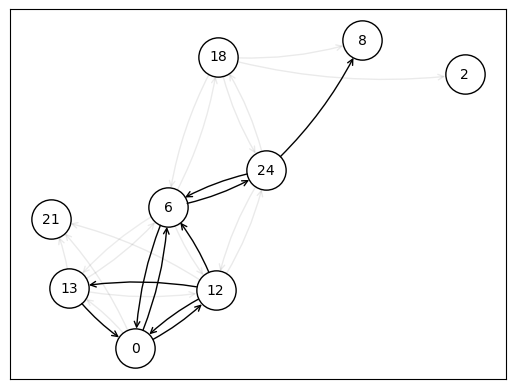

In [52]:
explanation.visualize_graph()

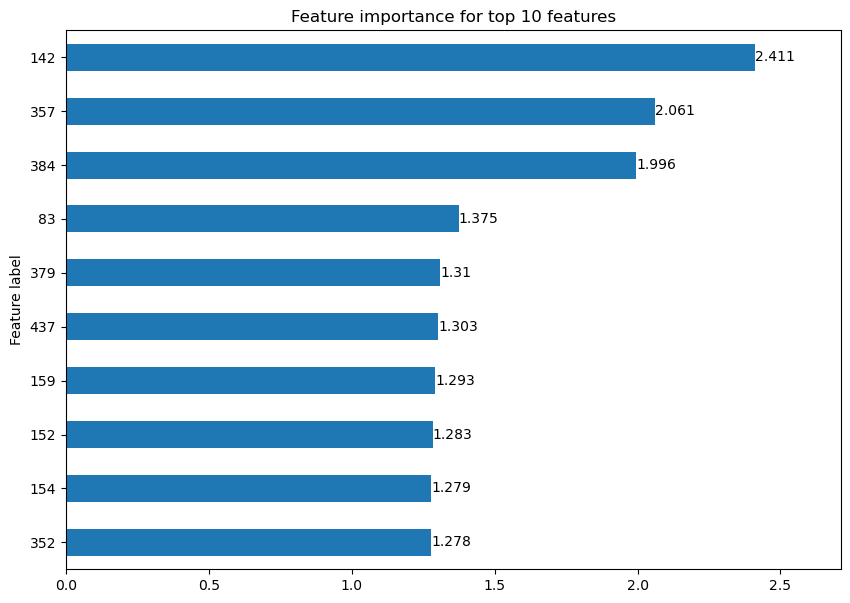

In [53]:
explanation.visualize_feature_importance(top_k=10)

## batch explanation, overall explanation

In [69]:
out_dir = r'.\spagnn\results\explainer'
for i in tqdm(range(len(edges))):
    single_cell_graph_x = proxi_by_cell.get_group(cell_ids[i])
    single_cell_graph_x = single_cell_graph_x.drop(columns=['index','cluster','row','col','z','cellID','index','patch_name'])
    single_cell_graph_x = single_cell_graph_x.values.astype('float')
    single_cell_graph_x = torch.Tensor(single_cell_graph_x)

    edge_index = np.array(edges[i]).T
    edge_index = edge_index - np.min(edge_index)
    single_cell_graph_edge_index = torch.LongTensor(edge_index)

    single_cell_graph = Data(x=single_cell_graph_x,edge_index=single_cell_graph_edge_index)
    single_cell_graph = t2(single_cell_graph)

    single_cell_graph.to(device)

    edge_index, edge_attr = remove_self_loops(single_cell_graph.edge_index, single_cell_graph.edge_attr)
    explanation = explainer(single_cell_graph.x, edge_index)

    edge_mask = explanation.edge_mask.detach().cpu().numpy()
    node_mask = explanation.node_mask.detach().cpu().numpy()

    with open(os.path.join(out_dir,cell_ids[i] + '.pkl'),'wb') as f:
        pickle.dump({'edge_mask':edge_mask,'node_mask':node_mask},f)

100%|██████████| 553/553 [20:02<00:00,  2.17s/it]


## Batch explanation, selected features

In [55]:
out_dir = r'.\spagnn\results\explainer'
for i in [6,12,24,46,59,71,75,78,87,96]:
    os.makedirs(os.path.join(out_dir, str(i)), exist_ok=True)

for i in tqdm(range(len(edges))):
    for idx in [6,12,24,46,59,71,75,78,87,96]:
        single_cell_graph_x = proxi_by_cell.get_group(cell_ids[i])
        single_cell_graph_x = single_cell_graph_x.drop(columns=['index','cluster','row','col','z','cellID','index','patch_name'])
        single_cell_graph_x = single_cell_graph_x.values.astype('float')
        single_cell_graph_x = torch.Tensor(single_cell_graph_x)

        edge_index = np.array(edges[i]).T
        edge_index = edge_index - np.min(edge_index)
        single_cell_graph_edge_index = torch.LongTensor(edge_index)

        single_cell_graph = Data(x=single_cell_graph_x,edge_index=single_cell_graph_edge_index)
        single_cell_graph = t2(single_cell_graph)

        single_cell_graph.to(device)

        edge_index, edge_attr = remove_self_loops(single_cell_graph.edge_index, single_cell_graph.edge_attr)
        explanation = explainer(single_cell_graph.x, edge_index, index=idx)

        edge_mask = explanation.edge_mask.detach().cpu().numpy()
        node_mask = explanation.node_mask.detach().cpu().numpy()

        with open(os.path.join(out_dir,str(idx),cell_ids[i] + '_' + 'feature' + str(idx) + '.pkl'),'wb') as f:
            pickle.dump({'edge_mask':edge_mask,'node_mask':node_mask},f)

  0%|          | 0/553 [00:04<?, ?it/s]


IndexError: index 24 is out of bounds for dimension 0 with size 23

## Explain phenomenon

In [84]:
explainer = Explainer(model=gae_model.encoder,
                      algorithm=GNNExplainer(epochs=200),
                      explanation_type='phenomenon',
                      node_mask_type='attributes',
                      edge_mask_type='object',
                      model_config=dict(mode='regression',
                                        task_level='graph',
                                        return_type='raw')
                    )

In [85]:
node_index=10
explanation = explainer(transformed_data.x, transformed_data.edge_index, index=node_index, target=z_embed)

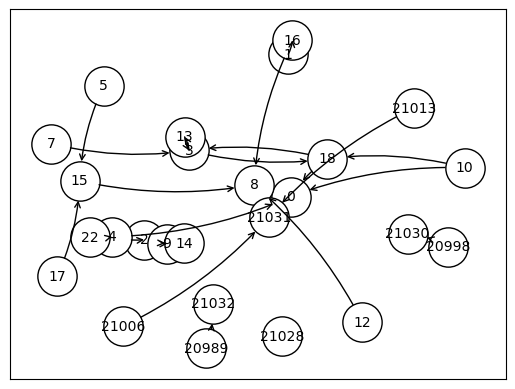

In [86]:
explanation.visualize_graph()

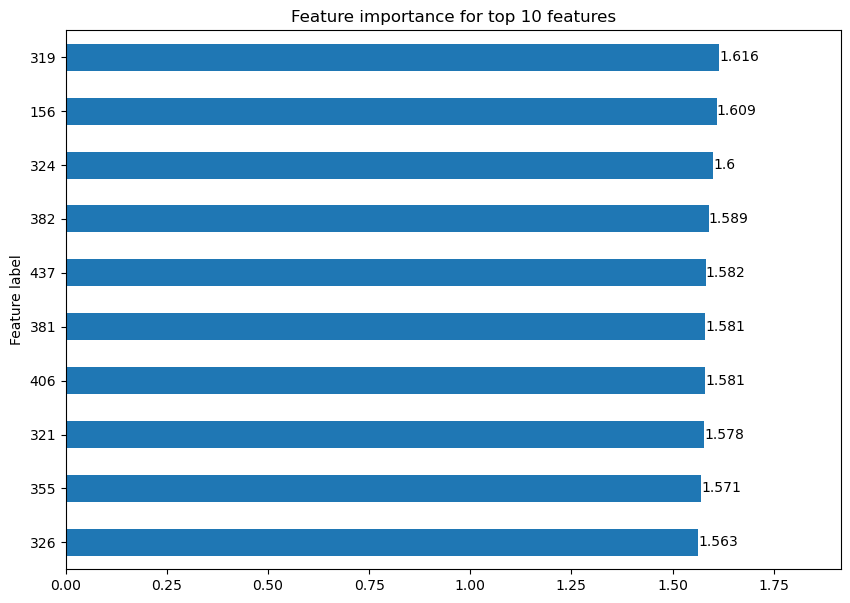

In [87]:
explanation.visualize_feature_importance(top_k=10)

# GAE hyperparameter tuning

In [76]:
NUM_FEATURES = x.shape[1]
HIDDEN_SIZE = np.arange(50,300, 25)
OUT_CHANNELS = np.arange(25,150,25)
EPOCHS = 1000

In [77]:
out_dir = r'.\spagnn\results\gae_hyperparameter'

In [84]:
for i in range(HIDDEN_SIZE.shape[0]):
    for j in range(OUT_CHANNELS.shape[0]):

        hidden_size = HIDDEN_SIZE[i]
        out_channels = OUT_CHANNELS[j]
        
        gae_model = GAE(GCNEncoder(NUM_FEATURES, hidden_size, out_channels, 0.5))
        gae_model = gae_model.to(device)
        
        # Train
        losses = []
        test_auc = []
        test_ap = []
        train_aucs = []
        train_aps = []
        
        optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.001)
        
        for epoch in range(1, EPOCHS + 1):
            loss = gae_train(train_set, gae_model, optimizer)
            losses.append(loss)
            auc, ap = gae_test(test_set, gae_model)
            test_auc.append(auc)
            test_ap.append(ap)
        
            train_auc, train_ap = gae_test(train_set, gae_model)
        
            train_aucs.append(train_auc)
            train_aps.append(train_ap)
        
            print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

        metadata = {'losses':losses,'test_auc':test_auc,'test_ap':test_ap,'train_aucs':train_aucs,'train_aps':train_aps}
        
        with torch.no_grad():
            z_embed = gae_model.encode(transformed_data.x, transformed_data.edge_index)

        z_embed = z_embed.cpu()
        numpy_z = z_embed.numpy()
        columns = list(np.arange(1,numpy_z.shape[1]+1))
        embedded_features = pd.DataFrame(index=index,data=numpy_z,columns=columns)

        metadata_name = str(hidden_size)+'_'+str(out_channels)+'_metadata.pkl'
        embedding_feature_name = str(hidden_size)+'_'+str(out_channels)+'_embedded_features.csv'

        with open(os.path.join(out_dir, metadata_name), 'wb') as f:
            pickle.dump(metadata, f)
        embedded_features.to_csv(os.path.join(out_dir,embedding_feature_name))

Epoch: 001, test AUC: 0.7185, test AP: 0.7303, train AUC: 0.7963, train AP: 0.7980, loss:7.5616
Epoch: 002, test AUC: 0.7646, test AP: 0.7743, train AUC: 0.8416, train AP: 0.8419, loss:5.0708
Epoch: 003, test AUC: 0.8050, test AP: 0.8117, train AUC: 0.8796, train AP: 0.8778, loss:3.5890
Epoch: 004, test AUC: 0.8333, test AP: 0.8383, train AUC: 0.9057, train AP: 0.9028, loss:2.6505
Epoch: 005, test AUC: 0.8493, test AP: 0.8530, train AUC: 0.9208, train AP: 0.9172, loss:2.0927
Epoch: 006, test AUC: 0.8572, test AP: 0.8597, train AUC: 0.9289, train AP: 0.9244, loss:1.8051
Epoch: 007, test AUC: 0.8612, test AP: 0.8627, train AUC: 0.9333, train AP: 0.9281, loss:1.6029
Epoch: 008, test AUC: 0.8640, test AP: 0.8650, train AUC: 0.9364, train AP: 0.9306, loss:1.4969
Epoch: 009, test AUC: 0.8669, test AP: 0.8677, train AUC: 0.9391, train AP: 0.9330, loss:1.4146
Epoch: 010, test AUC: 0.8698, test AP: 0.8708, train AUC: 0.9415, train AP: 0.9354, loss:1.3295
Epoch: 011, test AUC: 0.8724, test AP: 0

# vgae

In [206]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=False)
        self.conv_mu = GCNConv(hidden_size, out_channels, cached=False)
        self.conv_logstd = GCNConv(hidden_size, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv_mu(x_temp2, edge_index), self.conv_logstd(x_temp2, edge_index)


vgae_model = VGAE(VariationalGCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, dropout=0.5))
vgae_model = vgae_model.to(device)

In [207]:
def vgae_train(train_data, vgae_model, optimizer):
    optimizer.zero_grad()
    vgae_model.train()
    z = vgae_model.encode(train_data.x, train_data.edge_index)
    loss = (
        vgae_model.recon_loss(z, train_data.pos_edge_label_index.to(device)) +
        (1 / train_data.num_nodes) * vgae_model.kl_loss()
    )
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def vgae_test(test_data, vgae_model):
    vgae_model.eval()
    z = vgae_model.encode(test_data.x, test_data.edge_index)
    return vgae_model.test(z, test_data.pos_edge_label_index,
                      test_data.neg_edge_label_index)

In [209]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []


optimizer = torch.optim.Adam(vgae_model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    loss = vgae_train(train_set, vgae_model, optimizer)
    losses.append(loss)
    auc, ap = vgae_test(test_set, vgae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = vgae_test(train_set, vgae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.6986, test AP: 0.6840, train AUC: 0.7841, train AP: 0.7614, loss:20.0827
Epoch: 002, test AUC: 0.7960, test AP: 0.7960, train AUC: 0.8804, train AP: 0.8745, loss:11.6814
Epoch: 003, test AUC: 0.8300, test AP: 0.8275, train AUC: 0.9075, train AP: 0.9006, loss:5.8945
Epoch: 004, test AUC: 0.8665, test AP: 0.8652, train AUC: 0.9348, train AP: 0.9282, loss:3.8154
Epoch: 005, test AUC: 0.8436, test AP: 0.8419, train AUC: 0.9160, train AP: 0.9090, loss:2.8530
Epoch: 006, test AUC: 0.8296, test AP: 0.8268, train AUC: 0.9031, train AP: 0.8953, loss:2.6979
Epoch: 007, test AUC: 0.8499, test AP: 0.8486, train AUC: 0.9176, train AP: 0.9107, loss:2.5727
Epoch: 008, test AUC: 0.8678, test AP: 0.8666, train AUC: 0.9300, train AP: 0.9233, loss:2.3066
Epoch: 009, test AUC: 0.8725, test AP: 0.8705, train AUC: 0.9332, train AP: 0.9266, loss:2.1436
Epoch: 010, test AUC: 0.8764, test AP: 0.8746, train AUC: 0.9368, train AP: 0.9305, loss:1.9319
Epoch: 011, test AUC: 0.8844, test AP:

In [210]:
with torch.no_grad():
    z_vgae = vgae_model.encode(transformed_data.x, transformed_data.edge_index)

In [211]:
z_vgae = z_vgae.cpu()
numpy_z = z_vgae.numpy()

In [216]:
embedded_features = pd.DataFrame(index=index,data=numpy_z,columns=columns)
embedded_features = embedded_features.reset_index()

In [217]:
embedded_features.to_csv(r'.\spagnn\results\vgae_embedded_features.csv')